In [1]:
from glob import glob
import os
import os.path
import pandas as pd
import tempfile
import matplotlib.pyplot as plt

### Build a lookup dict for assigning population

In [2]:
lookup = {}
for line in open("/cbio/projects/012/stream1/hupan/1kg-100-samples/samples.tsv"):
    row = line.strip().split()
    lookup[row[0]] = row[2]

In [3]:
## function for reading cluster files

def read_clusters(clusterfilename):
    fout = tempfile.NamedTemporaryFile(mode="wt",delete=False)
    header = ["Cluster","Index","Length","Population","Sample","contig_id","Percentage"]
    fout.write("\t".join(header) + "\n")
    for i,line in enumerate(open(clusterfilename)):
        if line.startswith(">"):
            cluster_name = line.strip().replace(">Cluster ","")
        else:
            row = line.strip().split()
            if not line.strip().endswith("%"):
                j, length, contig, perc = row
                perc = "NA"
            else:
                j, length, contig, _, perc = row
                perc = perc.replace("+/","").replace("-/","").strip("%")
            length = length.replace("nt,","")
            sample,  contig_id = contig.split(":")
            pop = lookup[sample]
            outline = line.replace(sample,pop)
            outline = f"{cluster_name}\t{j}\t{length}\t{pop}\t{sample}\t{contig_id}\t{perc}\n"
            fout.write(outline)
    fout.close()
    
    df = pd.read_csv(fout.name,sep="\t")
    return df

### Transform **cluster_info.txt** into a dataframe tsv

In [4]:
CLUSTERSETS = {
    "before": "/cbio/projects/012/stream1/team/jess/HUPANrerun/07_rmredundant/" +
        "rmredundant.fully/cluster_info.txt",
    "after": "/cbio/projects/012/stream1/team/jess/HUPANrerun/07_rmredundant/" + \
        "rmredundant.partially/cluster_info.txt",\
    "final":"/cbio/projects/012/stream1/team/jess/HUPANrerun/12_finalpangenome/cluster_info.txt",    
}

DATASETNAME = "final"
DATASETNAME = "before"

CLUSTERFILE = CLUSTERSETS[DATASETNAME]

## Read in the two dataframes

In [5]:
df1 = read_clusters(CLUSTERSETS["before"])
df1["Source"] = "fully.unaligned"
df2 = read_clusters(CLUSTERSETS["after"])
df2["Source"] = "partially.unaligned"
topcount = df1.Cluster.max()
df2["Cluster"] = df2.Cluster + topcount + 1

In [6]:
df = df1.append(df2)

### 0. Some annotation

In [7]:
df['nContigs'] = df.groupby(['Cluster'])['Index'].transform(max)+1
df['ClusterLength'] = df.groupby(['Cluster'])['Length'].transform(max)
df['nSamples'] = df.groupby(['Cluster'])['Sample'].transform(lambda x: len(set(x)))
df['Pops'] = df.groupby(['Cluster'])['Population'].transform(lambda x: ','.join(sorted(set(x))))
df['nPops'] = df.groupby(['Cluster'])['Population'].transform(lambda x: len(set(x)))
df['Primary'] = df.Percentage.isna()
display (df)

,Cluster,Index,Length,Population,Sample,contig_id,Percentage,Source,nContigs,ClusterLength,nSamples,Pops,nPops,Primary
0,0,0,1084,MSL,HG03473,contig-6933487_1084_0,100.00,fully.unaligned,762,42830,93,"ESN,GWD,LWK,MSL,YRI",5,False
1,0,1,3444,MSL,HG03473,contig-8576943_3444_0,99.83,fully.unaligned,762,42830,93,"ESN,GWD,LWK,MSL,YRI",5,False
2,0,2,1126,MSL,HG03473,contig-9500491_1126_0,99.91,fully.unaligned,762,42830,93,"ESN,GWD,LWK,MSL,YRI",5,False
3,0,3,24827,MSL,HG03473,contig-10652849_24827_0,96.13,fully.unaligned,762,42830,93,"ESN,GWD,LWK,MSL,YRI",5,False
4,0,4,3857,ESN,HG02974,contig-7743119_3857_0,99.90,fully.unaligned,762,42830,93,"ESN,GWD,LWK,MSL,YRI",5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115475,23728,0,584,GWD,HG02561,contig-3087814_584_0,NaN,partially.unaligned,1,584,1,GWD,1,True
115476,23729,0,583,GWD,HG02679,contig-2842657_583_0,NaN,partially.unaligned,1,583,1,GWD,1,True
115477,23730,0,582,YRI,NA19129,contig-1010925_582_0,NaN,partially.unaligned,1,582,1,YRI,1,True
115478,23731,0,579,GWD,HG02583,contig-8378460_579_0,NaN,partially.unaligned,1,579,1,GWD,1,True


### 1. Remove singleton clusters

In [8]:
df_dup = df[df.nContigs > 1].copy(deep=True)
print(f"{len(df_dup)} contigs in non-singleton clusters. ({len(set(df_dup.Cluster))} clusters)")
df_dup.head()

334013 contigs in non-singleton clusters. (15255 clusters)


,Cluster,Index,Length,Population,Sample,contig_id,Percentage,Source,nContigs,ClusterLength,nSamples,Pops,nPops,Primary
0,0,0,1084,MSL,HG03473,contig-6933487_1084_0,100.00,fully.unaligned,762,42830,93,"ESN,GWD,LWK,MSL,YRI",5,False
1,0,1,3444,MSL,HG03473,contig-8576943_3444_0,99.83,fully.unaligned,762,42830,93,"ESN,GWD,LWK,MSL,YRI",5,False
2,0,2,1126,MSL,HG03473,contig-9500491_1126_0,99.91,fully.unaligned,762,42830,93,"ESN,GWD,LWK,MSL,YRI",5,False
3,0,3,24827,MSL,HG03473,contig-10652849_24827_0,96.13,fully.unaligned,762,42830,93,"ESN,GWD,LWK,MSL,YRI",5,False
4,0,4,3857,ESN,HG02974,contig-7743119_3857_0,99.90,fully.unaligned,762,42830,93,"ESN,GWD,LWK,MSL,YRI",5,False


In [9]:
df_singleton = df[df.nContigs == 1].copy(deep=True)
print(f"{len(df_singleton)} contigs in non-singleton clusters. ({len(set(df_singleton.Cluster))} clusters)")
df_singleton['Pops'].value_counts()

8478 contigs in non-singleton clusters. (8478 clusters)


MSL    1843
LWK    1685
YRI    1677
ESN    1666
GWD    1607
Name: Pops, dtype: int64

### 2. Simple membership calculation. i.e. XXX pop was found in what perc. of clusters?

In [10]:
#df = df[df.Source == "fully.unaligned"]
df_primaries = df[df.Primary]
#df_primaries = df_primaries[df_primaries.nPops==2].copy(deep=True)

In [11]:
total = df_primaries.Cluster.count()

In [12]:
def inside(row, popname):
    return popname in row["Pops"].split(",")

for popname in sorted(set(df.Population)):
    print(f"{popname} was found in", end=" ")
    df_m = df_primaries[df_primaries.apply(inside, axis=1,popname=popname)].copy(deep=True)
    matched = len(df_m)
    print(f"{matched} of the {total} clusters {100.0*matched/total:.2f}")

ESN was found in 12510 of the 23733 clusters 52.71
GWD was found in 12424 of the 23733 clusters 52.35
LWK was found in 12180 of the 23733 clusters 51.32
MSL was found in 12984 of the 23733 clusters 54.71
YRI was found in 12718 of the 23733 clusters 53.59


### 3. What coverage does each pop have of their clusters?

In [13]:
from collections import Counter

count = 0
lengths = set()
lc = Counter()
clusters = {}
sets = Counter()

for i,row in df.groupby(['Cluster']):
    assert len(set(row.nSamples)) == 1
    clusterlength = row.head(1).ClusterLength.values[0]
    pops = tuple(sorted(row.head(1).Pops.values[0].split(",")))
    sets[pops] += 1
    for popname in pops:
        df_pops = row[row.Population==popname]
        longest = df_pops.Length.max()
        is_primary = longest==clusterlength
        if popname in clusters:
            clusters[popname].append((i,longest,clusterlength,is_primary))
        else:
            clusters[popname] = [(i,longest,clusterlength,is_primary)]
    nSamples = max(row.nSamples)
    lc[nSamples] += 1
    if nSamples not in lengths:
        lengths.add(nSamples)
    count += 1
    if count % 1000==0:
        print(".",end="")

.......................

In [15]:
for popname in clusters:
    total = sum(k for i,j,k,p in clusters[popname] if not p)
    sums = sum(j for i,j,k,p in clusters[popname] if not p)
    print(f"{popname}: {sums}/{total} = {100.0*sums/total:.2f}%")

ESN: 16685490/28196872 = 59.17%
GWD: 15987856/25959055 = 61.59%
LWK: 16709261/27730467 = 60.26%
MSL: 16578305/27797311 = 59.64%
YRI: 16896819/27458297 = 61.54%


In [16]:
len(set(df.Cluster))

23733

### Upsetplot

<Figure size 576x576 with 0 Axes>

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


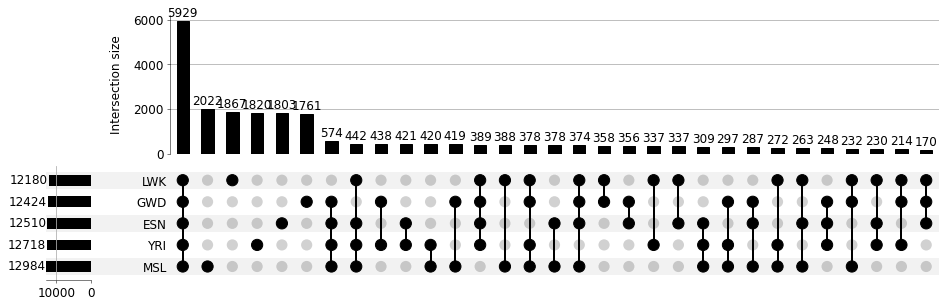

In [17]:
plt.style.use("~/.matplotstyle/scientific.mplstyle")

from upsetplot import from_memberships, plot
fig1 = plt.figure(figsize = (8,8))
keys, values = zip(*sets.most_common())
example = from_memberships(keys, values)
upset = plot(example, sort_by='cardinality', show_counts=True)
# plt.savefig('1kGUpset.svg', format='svg', dpi=1200)

#### Size (n samples) distribution of clusters

In [23]:
from collections import Counter
cnt = Counter(df.groupby(['Cluster'], sort=False)['Index'].max()+1).most_common()

In [24]:
n = sum([r[1] for r in cnt if r[0] > 1])
print(f"{n} clusters have more than one member")

15255 clusters have more than one member


In [25]:
len(set(df_dup.Cluster))

15255

In [26]:
df.count()

Cluster          342491
Index            342491
Length           342491
Population       342491
Sample           342491
contig_id        342491
Percentage       318758
Source           342491
nContigs         342491
ClusterLength    342491
nSamples         342491
Pops             342491
nPops            342491
Primary          342491
dtype: int64

In [27]:
df.groupby([df.Percentage.isna(),"Population"]).count()

Cluster  Index  Length  Sample  contig_id  Percentage  \
Percentage Population                                                          
False      ESN           67664  67664   67664   67664      67664       67664   
           GWD           57829  57829   57829   57829      57829       57829   
           LWK           58654  58654   58654   58654      58654       58654   
           MSL           67422  67422   67422   67422      67422       67422   
           YRI           67189  67189   67189   67189      67189       67189   
True       ESN            4471   4471    4471    4471       4471           0   
           GWD            4881   4881    4881    4881       4881           0   
           LWK            4555   4555    4555    4555       4555           0   
           MSL            4996   4996    4996    4996       4996           0   
           YRI            4830   4830    4830    4830       4830           0   

                       Source  nContigs  ClusterLength  nSamples   Pops  \
Percentage Population                                                     
False      ESN          67664     67664          67664     67664  67664   
           GWD          57829     57829          57829     57829  57829   
           LWK          58654     58654          58654     58654  58654   
           MSL          67422     67422          67422     67422  67422   
           YRI          67189     67189          67189     67189  67189   
True       ESN           4471      4471           4471      4471   4471   
           GWD           4881      4881           4881      4881   4881   
           LWK           4555      4555           4555      4555   4555   
           MSL           4996      4996           4996      4996   4996   
           YRI           4830      4830           4830      4830   4830   

                       nPops  Primary  
Percentage Population                  
False      ESN         67664    67664  
           GWD         57829    57829  
           LWK         58654    58654  
           MSL         67422    67422  
           YRI         67189    67189  
True       ESN          4471     4471  
           GWD          4881     4881  
           LWK          4555     4555  
           MSL          4996     4996  
           YRI          4830     4830

In [29]:
fout = open("renamed_cluster_info.txt","wt")
for i,line in enumerate(open("/cbio/projects/012/stream1/hupan/1kg-100-samples/NonredundantNonreference/cluster_info.txt")):
    if line.startswith(">"):
        fout.write(line)
    else:
        row = line.strip().split()
        if not line.strip().endswith("%"):
            j, length, contig, perc = row
        else:
            j, length, contig, perc, perc2 = row
        sample,  contig_id = contig.split(":")
        pop = lookup[sample]
        outline = line.replace(sample,pop)
        #outline = f"{j}\t{length} {pop}:{contig_id} {perc}\n"
        #print(outline)
        fout.write(outline)
fout.close()

In [30]:
from sklearn.decomposition import PCA

In [31]:
matrix = []
allsamples = sorted(set(df.Sample))

matrix = [[lookup[sample],sample] for sample in allsamples]
header = ["Population","Sample"]

for cluster_id,row in df.groupby("Cluster"):
    samples = set(row.Sample)
    header.append(f"{cluster_id}")
    for i,sample in enumerate(allsamples):
        if sample in samples:
            matrix[i].append(1)
        else:
            matrix[i].append(0)

In [32]:
dfm = pd.DataFrame(matrix, columns=header)
dfm.head()

,Population,Sample,0,1,2,3,4,5,6,7,...,23723,23724,23725,23726,23727,23728,23729,23730,23731,23732
0,GWD,HG02461,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,GWD,HG02561,1,1,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,GWD,HG02573,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,GWD,HG02583,1,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,GWD,HG02679,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0


In [33]:
x = dfm[header[2:]].values
len(x)

95

In [34]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

In [35]:
finalDf = pd.concat([principalDf, dfm[['Population','Sample']]], axis = 1)

In [36]:
set(finalDf.Population)

{'ESN', 'GWD', 'LWK', 'MSL', 'YRI'}

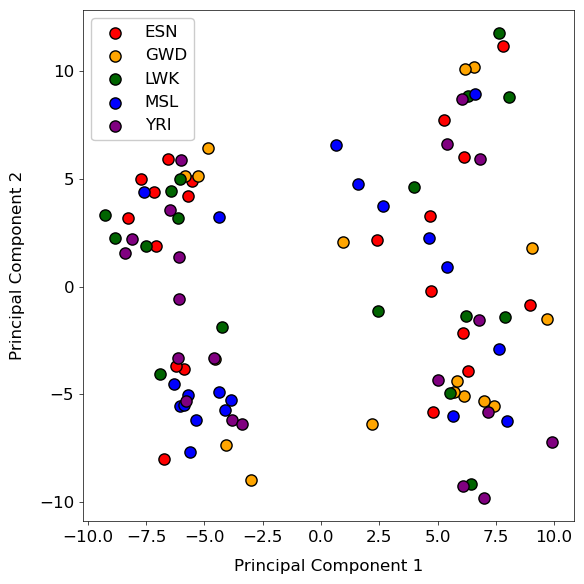

In [39]:
plt.style.use("~/.matplotstyle/scientific.mplstyle")
#plt.style.use('default')

plt.figure(figsize = (6, 6))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
targets = ['ESN', 'GWD', 'LWK', 'MSL', 'YRI']
colors = ['red', 'orange', 'darkgreen','blue','purple']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Population'] == target
    plt.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2'], marker = 'o', edgecolors = 'black'
               , c = color
               , s = 65)
plt.legend(targets, loc = 'upper left')
#plt.savefig('1kGpca.svg', format='svg', dpi=1200)

In [40]:
finalDf

,PC1,PC2,Population,Sample
0,-5.267610,5.133168,GWD,HG02461
1,6.579345,10.199093,GWD,HG02561
2,-5.837753,5.124926,GWD,HG02573
3,2.202719,-6.351257,GWD,HG02583
4,7.428101,-5.554561,GWD,HG02679
...,...,...,...,...
90,6.442246,-9.138972,LWK,NA19448
91,-4.252311,-1.859010,LWK,NA19463
92,6.209480,-1.343008,LWK,NA19467
93,7.898317,-1.385756,LWK,NA19471
